# 4.2 Supervised Learning with Random Forest

In [97]:
import os
import sys
import re
import csv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

## Load image paths from google drive. To use the local files, change `google_path` to `.`

In [98]:
google_path = '/content/drive/MyDrive'
path = os.path.join(google_path, 'QC')
train_test_path = os.path.join(path, 'split')
mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")

# Load training and validation csv files
def load_subjects(csv_path):
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        subjects = list(reader)
    return subjects[1:]

train_subjects = load_subjects(os.path.join(train_test_path, 'train_subjects.csv'))
val_subjects = load_subjects(os.path.join(train_test_path, 'validate_subjects.csv'))

## Load images and masks； Extract and downsample pixels

In [99]:
# Match images with the labels in the csv file
def get_image_mask_pairs(subjects):
    images = []
    masks = []
    for patient in subjects:
        for file in os.listdir(rgb_path):
            if re.match(patient[0], file):
                images.append(os.path.join(rgb_path, file))
                masks.append(os.path.join(mask_path, file))
    return images, masks

train_images, train_masks = get_image_mask_pairs(train_subjects)
val_images, val_masks = get_image_mask_pairs(val_subjects)


def extract_downsampled_pixel_features_labels(images, masks, target_size=(256,256), sample_fraction=0.05, threshold_value=10):

    X_list, Y_list = [], []

    for img_path, mask_path in zip(images, masks):
        # Read the image and masks
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        img_resized = cv.resize(img, target_size)

        mask_color = cv.imread(mask_path, cv.IMREAD_COLOR)
        mask_resized = cv.resize(mask_color, target_size)

        # Extract the masks and convert it into a binary one with threshold value
        mask_channel = mask_resized[:, :, 0]
        _, mask_bin = cv.threshold(mask_channel, threshold_value, 255, cv.THRESH_BINARY)
        mask_bin = (mask_bin // 255).astype(np.float32)

        # Flatten the image and the mask.
        img_flat = img_resized.flatten()
        mask_flat = mask_bin.flatten()

        # Randomly sample a fraction of pixels.
        num_pixels = len(img_flat)
        sample_size = int(num_pixels * sample_fraction)
        indices = np.random.choice(num_pixels, sample_size, replace=False)

        X_list.append(img_flat[indices])
        Y_list.append(mask_flat[indices])

    X_down = np.concatenate(X_list).reshape(-1, 1)
    Y_down = np.concatenate(Y_list)
    return X_down, Y_down

## Train the random forest model

In [100]:
X_down_train, Y_down_train = extract_downsampled_pixel_features_labels(train_images, train_masks, sample_fraction=0.05)
X_down_val, Y_down_val = extract_downsampled_pixel_features_labels(val_images, val_masks, sample_fraction=0.05)

# Apply a max depth to avoid the overfitting
clf_down = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, max_depth=30)
clf_down.fit(X_down_train, Y_down_train)

Y_down_train_pred = clf_down.predict(X_down_train)
Y_down_val_pred = clf_down.predict(X_down_val)

## Evaluate the model with ACC, AUC and other metrics

=== Downsampled Pixel-Level Classification (Thresholded) ===
Training Accuracy: 0.8382349444147197
Training AUC: 0.762609075692424
Training Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.98      0.91   3636459
         1.0       0.58      0.15      0.24    737001

    accuracy                           0.84   4373460
   macro avg       0.71      0.57      0.58   4373460
weighted avg       0.80      0.84      0.80   4373460

Validation Accuracy: 0.8428550531240018
Validation AUC: 0.7811157800039081
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91   1121907
         1.0       0.60      0.10      0.18    217977

    accuracy                           0.84   1339884
   macro avg       0.72      0.54      0.54   1339884
weighted avg       0.81      0.84      0.79   1339884



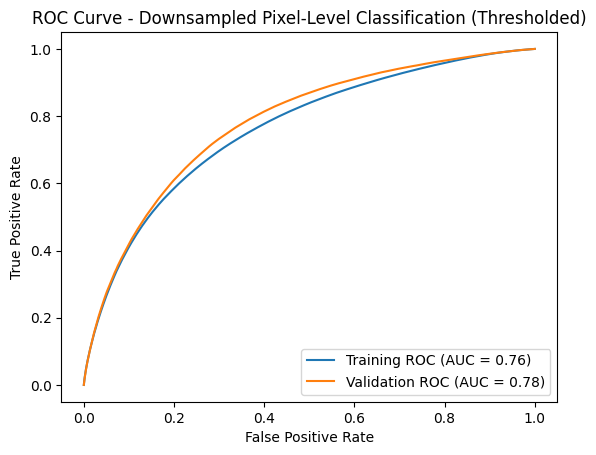

In [101]:
# Compute predicted probabilities for patch-based classifier
print("=== Downsampled Pixel-Level Classification (Thresholded) ===")
print("Training Accuracy:", accuracy_score(Y_down_train, Y_down_train_pred))
print("Training AUC:", roc_auc_score(Y_down_train, clf_down.predict_proba(X_down_train)[:, 1]))
print("Training Classification Report:")
print(classification_report(Y_down_train, Y_down_train_pred, zero_division=0))
print("Validation Accuracy:", accuracy_score(Y_down_val, Y_down_val_pred))
print("Validation AUC:", roc_auc_score(Y_down_val, clf_down.predict_proba(X_down_val)[:, 1]))
print("Validation Classification Report:")
print(classification_report(Y_down_val, Y_down_val_pred, zero_division=0))

# Plot ROC Curves
fpr_train, tpr_train, _ = roc_curve(Y_down_train, clf_down.predict_proba(X_down_train)[:, 1])
fpr_val, tpr_val, _ = roc_curve(Y_down_val, clf_down.predict_proba(X_down_val)[:, 1])

plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {roc_auc_score(Y_down_train, clf_down.predict_proba(X_down_train)[:,1]):.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {roc_auc_score(Y_down_val, clf_down.predict_proba(X_down_val)[:,1]):.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Downsampled Pixel-Level Classification (Thresholded)")
plt.legend(loc="lower right")
plt.show()

## Show sample images

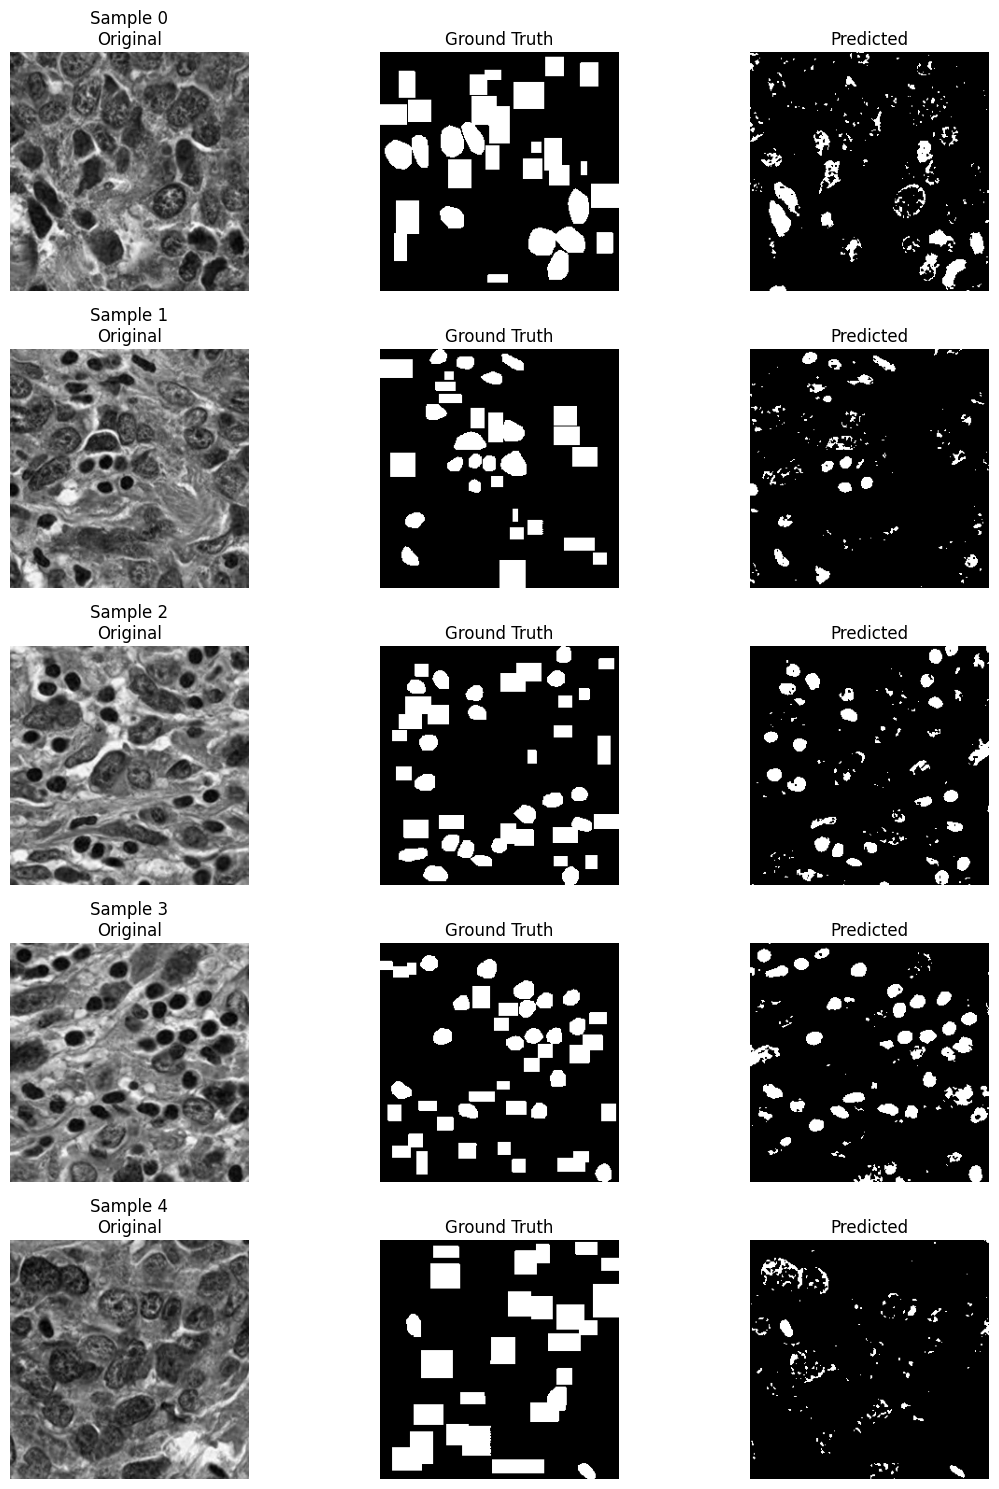

In [102]:
def predict_mask_from_image(image_path, model, target_size=(256,256)):

    # Read the image and resize it
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    img_resized = cv.resize(img, target_size)
    X = img_resized.flatten().reshape(-1, 1)

    # Predict labels (0 or 1) for each pixel
    y_pred = model.predict(X)
    # Reshape predictions to the original image dimensions
    mask_pred = y_pred.reshape(target_size)
    mask_pred_vis = (mask_pred * 255).astype(np.uint8)
    return mask_pred_vis

def get_ground_truth_mask(mask_path, target_size=(256,256), threshold_value=10):

    mask_color = cv.imread(mask_path, cv.IMREAD_COLOR)
    mask_resized = cv.resize(mask_color, target_size)

    mask_channel = mask_resized[:, :, 0]
    # Apply the manual threshold
    _, mask_bin = cv.threshold(mask_channel, threshold_value, 255, cv.THRESH_BINARY)
    return mask_bin

# Define a list of sample indices to display (for example, 5 images)
sample_indices = [0, 1, 2, 3, 4]

# Set target image size for display
target_size = (256, 256)

# Create a figure with 5 rows and 3 columns: Original, Ground Truth, and Predicted
num_samples = len(sample_indices)
plt.figure(figsize=(12, 3*num_samples))

for idx, sample_index in enumerate(sample_indices):
    image_path = train_images[sample_index]
    mask_path = train_masks[sample_index]

    # Predict the mask using the trained classifier (clf_down)
    pred_mask = predict_mask_from_image(image_path, clf_down, target_size=target_size)
    # Get the ground truth binary mask using the threshold method
    gt_mask = get_ground_truth_mask(mask_path, target_size=target_size, threshold_value=10)
    # Read and resize the original image for display
    orig_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    orig_img_resized = cv.resize(orig_img, target_size)

    # Plot the original image, ground truth mask, and predicted mask in one row
    plt.subplot(num_samples, 3, idx*3 + 1)
    plt.imshow(orig_img_resized, cmap='gray')
    plt.title(f"Sample {sample_index}\nOriginal")
    plt.axis("off")

    plt.subplot(num_samples, 3, idx*3 + 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 3, idx*3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()